# 휘발유와 경유 가격은 셀프 주유소에서 정말 저렴할까?
주유소 분석을 위한 지역은 서울로 제한을 한다.

## 문제1. 서울시 구별 주유소 데이터 정보 크롤링
- https://www.opinet.co.kr/searRgSelect.do
- 목표
    - 수집한 데이터들을 pandas 데이터프레임으로 정리 
    - 부가 정보 데이터 : Y 또는 N 으로 저장
    - 컬럼 이름은 영문으로 작성
- 수집 데이터
    - 주유소명(StationName)
    - 주소(Address)
    - 브랜드(Brand)
    - 휘발유 가격(GasolinePrice)
    - 경유 가격(DieselPrice)
    - 셀프 여부(SelfService)
    - 세차장 여부(CarWash)
    - 충전소 여부(ChargingStation)
    - 경정비 여부(Maintenance)
    - 편의점 여부(ConvenienceStore)
    - 24시간 운영 여부(Open24Hours)
    - 구(Gu)
    - 위도(Latitude)
    - 경도(Longitude)

In [43]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options

options = Options()
options.add_argument("start-maximized")

In [44]:
url = 'https://www.opinet.co.kr/searRgSelect.do'
driver = webdriver.Chrome(options=options)
driver.get(url)

### 부가정보(세차장, 경정비, 편의점, 24시간) 선택

#### 세차장

In [45]:
def check_car_wash_btn():
    car_wash_btn = driver.find_element(By.CSS_SELECTOR, '#CWSH_YN')
    if not car_wash_btn.is_selected():
        car_wash_btn.click()
check_car_wash_btn()

#### 경정비

In [46]:
def check_maintainance_btn():
    maintainance_btn = driver.find_element(By.CSS_SELECTOR, '#MAINT_YN')
    if not maintainance_btn.is_selected():
        maintainance_btn.click()
check_maintainance_btn()

#### 편의점

In [47]:
def check_conve_store_btn():
    conve_store_btn = driver.find_element(By.CSS_SELECTOR, '#CVS_YN')
    if not conve_store_btn.is_selected():
        conve_store_btn.click()
check_conve_store_btn()

#### 24시간

In [48]:
def check_24hours_btn():
    hours_btn = driver.find_element(By.CSS_SELECTOR, '#SEL24_YN')
    if not hours_btn.is_selected():
        hours_btn.click()
check_24hours_btn()

### '서울시' 선택

In [49]:
sido_list_raw = driver.find_element(By.ID, 'SIDO_NM0')
sido_list = sido_list_raw.find_elements(By.TAG_NAME, 'option')

sido_names = []

for option in sido_list:
    if option.text != '시/도':
        sido_names.append(option.get_attribute("value"))

sido_list_raw.send_keys(sido_names[0])

### 지역: 구 리스트 추출

In [50]:
gu_list_raw = driver.find_element(By.ID, 'SIGUNGU_NM0')
gu_list_raw.text

'시/군/구\n강남구\n강동구\n강북구\n강서구\n관악구\n광진구\n구로구\n금천구\n노원구\n도봉구\n동대문구\n동작구\n마포구\n서대문구\n서초구\n성동구\n성북구\n송파구\n양천구\n영등포구\n용산구\n은평구\n종로구\n중구\n중랑구'

In [51]:
gu_list = gu_list_raw.find_elements(By.TAG_NAME, 'option')
gu_list[0].text, gu_list[1].text

('시/군/구', '강남구')

In [52]:
gu_names = []

for option in gu_list:
    if option.text != '시/군/구':
        gu_names.append(option.get_attribute('value'))

gu_names

['강남구',
 '강동구',
 '강북구',
 '강서구',
 '관악구',
 '광진구',
 '구로구',
 '금천구',
 '노원구',
 '도봉구',
 '동대문구',
 '동작구',
 '마포구',
 '서대문구',
 '서초구',
 '성동구',
 '성북구',
 '송파구',
 '양천구',
 '영등포구',
 '용산구',
 '은평구',
 '종로구',
 '중구',
 '중랑구']

In [56]:
gu_list_raw = driver.find_element(By.ID, 'SIGUNGU_NM0')
gu_list_raw.send_keys(gu_names[3])

### 지역: 구 데이터 모두 수집

In [72]:
import time
from bs4 import BeautifulSoup

station_name = []
address = []
brand = []
gasoline_price = []
diesel_price = []
self_service = []
car_wash = []
charging_station = []
maintainance = []
cvs = []
open_24hours = []
gu = []

for gu_name in gu_names:
    # 구선택
    gu_list_raw = driver.find_element(By.ID, 'SIGUNGU_NM0')
    gu_list_raw.send_keys(gu_name)
    time.sleep(5)
    
    soup = BeautifulSoup(driver.page_source, "html.parser")
    datas = soup.select('#body1 > tr')
    
    for i in range(0, len(datas)):
        # 셀프주유 여부
        service_tag = datas[i].select_one('.ico')
        tmp = None if service_tag == None else service_tag.text
        self_service.append('Y' if tmp == '셀프' else 'N')

        # 휘발유 가격
        gasoline_price.append(datas[i].select('.price')[0].text.strip())
        
        # 경유 가격
        diesel_price.append(datas[i].select('.price')[1].text.strip())
        
        # 브랜드
        brand.append(datas[i].select_one('.rlist > img')['alt'])
        
        # 요소 클릭(팝업 데이터 이용 위함)
        driver.find_element(By.XPATH, '//*[@id="body1"]/tr['+ str(i+1) +']/td[1]/a').click() 
        time.sleep(5)
        
        # 팝업 html
        soup = BeautifulSoup(driver.page_source, "html.parser")
        station_info = soup.select_one('#os_dtail_info > div.inner')
        
        # 주유소명
        station_name.append(station_info.select_one('.inner > .header > label').text)
                   
        # 주소
        address.append(station_info.select_one('#rd_addr').text)
                   
        # 구
        gu.append(address[-1].split()[1])
                   
        # 세차장 여부
        car_wash.append('N' if 'off' in station_info.select_one('#cwsh_yn')['src'] else 'Y')
                   
        # 충전소 여부
        charging_station.append('N' if 'off' in station_info.select_one('#lpg_yn')['src'] else 'Y')
                   
        # 경정비 여부
        maintainance.append('N' if 'off' in station_info.select_one('#maint_yn')['src'] else 'Y')
                   
        # 편의점 여부
        cvs.append('N' if 'off' in station_info.select_one('#cvs_yn')['src'] else 'Y')
        
        # 24시간 운영 여부
        open_24hours.append('N' if 'off' in station_info.select_one('#sel24_yn')['src'] else 'Y')

In [73]:
len(station_name), len(address), len(brand), len(gasoline_price), len(diesel_price), len(self_service), 
len(car_wash), len(charging_station), len(maintainance), len(cvs), len(open_24hours), len(gu)

(355, 355, 355, 355, 355, 355)

In [74]:
import pandas as pd

df = pd.DataFrame({
    "station_name" : station_name,
    "address": address,
    "brand": brand,
    "gasoline_price": gasoline_price,
    "diesel_price": diesel_price,
    "self_service": self_service,
    "car_wash": car_wash,
    "charging_station": charging_station,
    "maintainance": maintainance,
    "cvs": cvs,
    "open_24hours": open_24hours,
    "gu": gu
})
df.head()

station_name                address     brand  ... cvs open_24hours   gu
0  HD현대오일뱅크㈜직영 강남셀프주유소         서울 강남구 도곡로 208  HD현대오일뱅크  ...   N            N  강남구
1          (주)보성 세곡주유소  서울 강남구  헌릉로 731 (세곡동)     SK에너지  ...   N            N  강남구
2                방죽주유소  서울 강남구 밤고개로 215 (율현동)     GS칼텍스  ...   N            N  강남구
3  HD현대오일뱅크㈜직영 산성셀프주유소         서울 강남구 헌릉로 730  HD현대오일뱅크  ...   N            N  강남구
4              자곡셀프주유소  서울 강남구 밤고개로 120 (자곡동)     SK에너지  ...   N            N  강남구

[5 rows x 12 columns]

#### 엑셀에 저장

In [75]:
df.to_csv("./data/station", sep=",", encoding="utf-8")

In [77]:
df = pd.read_csv("./data/station", encoding="utf-8", index_col=0)
df.head()

station_name                address     brand  ...  cvs  open_24hours   gu
0  HD현대오일뱅크㈜직영 강남셀프주유소         서울 강남구 도곡로 208  HD현대오일뱅크  ...    N             N  강남구
1          (주)보성 세곡주유소  서울 강남구  헌릉로 731 (세곡동)     SK에너지  ...    N             N  강남구
2                방죽주유소  서울 강남구 밤고개로 215 (율현동)     GS칼텍스  ...    N             N  강남구
3  HD현대오일뱅크㈜직영 산성셀프주유소         서울 강남구 헌릉로 730  HD현대오일뱅크  ...    N             N  강남구
4              자곡셀프주유소  서울 강남구 밤고개로 120 (자곡동)     SK에너지  ...    N             N  강남구

[5 rows x 12 columns]

#### 먼저, 강남구 데이터 수집

In [54]:
# 강남구 선택
gu_list_raw.send_keys(gu_names[0])

In [55]:
# 조회 버튼 클릭
driver.find_element(By.CSS_SELECTOR, '#searRgSelect').click()

In [59]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(driver.page_source, "html.parser")

In [62]:
datas = soup.select('#body1 > tr')

In [68]:
datas[0]

<tr>
<td class="rlist">
<img alt="GS칼텍스" src="/images/user/com/ico_logo_gs.gif"/>
<a href="javascript:fn_osPop('','1850','1627','1477','1600','','2024-08-17 17:55:34','2024-08-17 17:58:51','2024-08-17 17:56:36','2024-08-16 05:34:09','','318949.33634','553926.04177','*유류세 인하 적용*&lt;br/&gt;세차 6만원 이상 주유시 &lt;br/&gt;*승용차  5천원&lt;br/&gt;*RV차량 6천원&lt;br/&gt;*전기차도 *세차 할인*가격!&lt;br/&gt;부담 없이 이용하세요!','','최신형 세차기 교체※버블세차,하부세차※ 연중무휴  &lt;br/&gt;애플페이,바로주유 가능','','공공조달 기존처럼 이용가능! 세차장&lt;br/&gt;주유소 영업시간 06:00~23:00',' ','Y','N','GSC','대원주유소','GS칼텍스','02-438-6111','서울 중랑구 동일로 600','Y','N','N','','N','A0009180','2978501541','N','N','N');">
																
																															
																
																	
																	대원주유소
																</a>
<span class="ic ico_self"><span class="ico">셀프</span></span>
</td>
<td class="price">
																
																1627
															</td>
<td class="price">
<span style="color:gray;">
																
																1477
											

In [70]:
datas[0].select_one('.rlist > img')['alt']

'GS칼텍스'

In [ ]:
service_tag = datas[0].select_one('.ico')
tmp = None if service_tag == None else service_tag.text
self_service = 'Y' if tmp == '셀프' else 'N'

In [97]:
gasoline = datas[0].select('.price')[0].text.strip()
gasoline

'1699'

In [98]:
diesel = datas[0].select('.price')[1].text.strip()
diesel

'1599'

In [71]:
driver.find_element(By.XPATH, '//*[@id="body1"]/tr[1]/td[1]/a').click() # tr[0+1]

In [72]:
soup = BeautifulSoup(driver.page_source, "html.parser")
station_info = soup.select_one('#os_dtail_info > div.inner')

In [80]:
station_name = station_info.select_one('.inner > .header > label').text
station_name

'HD현대오일뱅크㈜직영 강남셀프주유소'

In [81]:
address = station_info.select_one('#rd_addr').text
address

'서울 강남구 도곡로 208'

In [ ]:
gu = address.split()[1]

In [82]:
brand = station_info.select_one('#rd_addr').text
brand

'서울 강남구 도곡로 208'

In [ ]:
car_wash = 'N' if 'off' in station_info.select_one('#cwsh_yn')['src'] else 'Y'
car_wash

In [85]:
charging_station = 'N' if 'off' in station_info.select_one('#lpg_yn')['src'] else 'Y'
charging_station

'N'

In [86]:
maintainance = 'N' if 'off' in station_info.select_one('#maint_yn')['src'] else 'Y'
maintainance

'N'

In [87]:
cvs = 'N' if 'off' in station_info.select_one('#cvs_yn')['src'] else 'Y'
cvs

'N'

In [88]:
open_24hours = 'N' if 'off' in station_info.select_one('#sel24_yn')['src'] else 'Y'
open_24hours

'N'

In [42]:
driver.close()

## 문제2. 이디야 매장 위치 데이터 수집
- https://ediya.com/contents/find_store.html
- 수집 목표
    - 이디야 매장의 이름
    - 매장 주소
    - 구 이름 

In [54]:
url = 'https://ediya.com/contents/find_store.html'
driver = webdriver.Chrome()
driver.get(url)

In [55]:
# 주소 탭 클릭
driver.find_element(
    By.CSS_SELECTOR, 
    '#contentWrap > div.contents > div > div.store_search_pop > ul > li:nth-child(2) > a'
).click()

In [56]:
# 서울시 구 이름 리스트
gu_list = starbucks["구"].unique()
gu_list, len(gu_list)

(array(['강남구', '강북구', '강서구', '관악구', '광진구', '금천구', '노원구', '도봉구', '동작구',
        '마포구', '서대문구', '서초구', '성북구', '송파구', '양천구', '영등포구', '은평구', '종로구',
        '중구', '강동구', '구로구', '동대문구', '성동구', '용산구', '중랑구'], dtype=object),
 25)

In [57]:
# 입력창 input, button 
input = driver.find_element(By.CSS_SELECTOR, '#keyword')
submit_btn = driver.find_element(By.CSS_SELECTOR, '#keyword_div > form > button')

In [58]:
ediya_name = []
ediya_address = []
ediya_gu = []

for gu in gu_list:
    input.clear()
    input.send_keys('서울 ' + gu)
    submit_btn.click()

    ediya_tmp_html = driver.page_source

    soup = BeautifulSoup(ediya_tmp_html, "html.parser")

    for ediya in soup.select_one('#placesList').select('li'):
        ediya_name.append(ediya.select_one('dt').get_text())
        ediya_address.append(ediya.select_one('dd').get_text())
        ediya_gu.append(ediya.select_one('dd').get_text().split()[1])

len(ediya_name), len(ediya_address), len(ediya_gu) 

(582, 582, 582)

In [59]:
ediya = pd.DataFrame({
    '매장 이름' : ediya_name, 
    '주소': ediya_address,
    '구': ediya_gu
})

ediya.head()

매장 이름                           주소    구
0      강남YMCA점                   서울 강남구 논현동  강남구
1  강남구청역아이티웨딩점  서울 강남구 학동로 338 (논현동, 강남파라곤)  강남구
2      강남논현학동점      서울 강남구 논현로131길 28 (논현동)  강남구
3        강남대치점   서울 강남구 역삼로 415 (대치동, 성진빌딩)  강남구
4        강남도산점      서울 강남구 도산대로37길 20 (신사동)  강남구

In [60]:
ediya["구"].unique(), len(ediya["구"].unique())

(array(['강남구', '강북구', '강서구', '관악구', '광진구', '금천구', '노원구', '도봉구', '동작구',
        '마포구', '서대문구', '서초구', '성북구', '송파구', '양천구', '영등포구', '은평구', '종로구',
        '중구', '동대문구', '강동구', '구로구', '성동구'], dtype=object),
 23)

## 문제3. 분석 및 분석 결과

In [61]:
# 구글 API secret 가져오기
from dotenv import load_dotenv
import os

load_dotenv('../source_code/.env')
gmaps_key = os.environ.get('GCP_API_KEY')

In [62]:
# 구글 API 사용 준비

import googlemaps

gmaps = googlemaps.Client(key=gmaps_key)

In [63]:
# 스타벅스 df 에 lat, lng 컬럼 추가

lat = []
lng = []

for idx, row in starbucks.iterrows():
    gmaps_output = gmaps.geocode(row["주소"])
    lat.append(gmaps_output[0]['geometry']['location']['lat'])
    lng.append(gmaps_output[0]['geometry']['location']['lng'])

starbucks['lat'] = lat
starbucks['lng'] = lng
starbucks.head()

매장 이름                          주소    구        lat         lng
0  역삼아레나빌딩     서울특별시 강남구 언주로 425 (역삼동)  강남구  37.500078  127.038542
1   논현역사거리    서울특별시 강남구 강남대로 538 (논현동)  강남구  37.513679  127.031712
2  신사역성일빌딩    서울특별시 강남구 강남대로 584 (논현동)  강남구  37.513679  127.031712
3   국기원사거리             서울특별시 강남구 테헤란로   강남구  37.504107  127.047588
4   대치재경빌딩  서울특별시 강남구 남부순환로 2947 (대치동)  강남구  37.494525  127.062584

In [65]:
# 엑셀로 저장
starbucks.to_csv("../data/eda1_starbucks", sep=",", encoding="utf-8")

In [66]:
# 이디야 df 에 lat, lng 컬럼 추가

lat = []
lng = []

for idx, row in ediya.iterrows():
    gmaps_output = gmaps.geocode(row["주소"])
    lat.append(gmaps_output[0]['geometry']['location']['lat'])
    lng.append(gmaps_output[0]['geometry']['location']['lng'])

ediya['lat'] = lat
ediya['lng'] = lng
ediya.head()

매장 이름                           주소    구        lat         lng
0      강남YMCA점                   서울 강남구 논현동  강남구  37.513679  127.031712
1  강남구청역아이티웨딩점  서울 강남구 학동로 338 (논현동, 강남파라곤)  강남구  37.516551  127.040139
2      강남논현학동점      서울 강남구 논현로131길 28 (논현동)  강남구  37.515190  127.027554
3        강남대치점   서울 강남구 역삼로 415 (대치동, 성진빌딩)  강남구  37.501434  127.052328
4        강남도산점      서울 강남구 도산대로37길 20 (신사동)  강남구  37.522282  127.031480

In [67]:
# 엑셀로 저장
ediya.to_csv("../data/eda1_ediya", sep=",", encoding="utf-8")

In [68]:
# 엑셀 불러오기 
startucks = pd.read_csv(
    "../data/eda1_starbucks", index_col=0, encoding="utf-8") # index_col "구분"을 인덱스 컬럼으로 설정
starbucks.head()

매장 이름                          주소    구        lat         lng
0  역삼아레나빌딩     서울특별시 강남구 언주로 425 (역삼동)  강남구  37.500078  127.038542
1   논현역사거리    서울특별시 강남구 강남대로 538 (논현동)  강남구  37.513679  127.031712
2  신사역성일빌딩    서울특별시 강남구 강남대로 584 (논현동)  강남구  37.513679  127.031712
3   국기원사거리             서울특별시 강남구 테헤란로   강남구  37.504107  127.047588
4   대치재경빌딩  서울특별시 강남구 남부순환로 2947 (대치동)  강남구  37.494525  127.062584

In [69]:
# 엑셀 불러오기 
ediya = pd.read_csv(
    "../data/eda1_ediya", index_col=0, encoding="utf-8") # index_col "구분"을 인덱스 컬럼으로 설정
starbucks.head()

매장 이름                          주소    구        lat         lng
0  역삼아레나빌딩     서울특별시 강남구 언주로 425 (역삼동)  강남구  37.500078  127.038542
1   논현역사거리    서울특별시 강남구 강남대로 538 (논현동)  강남구  37.513679  127.031712
2  신사역성일빌딩    서울특별시 강남구 강남대로 584 (논현동)  강남구  37.513679  127.031712
3   국기원사거리             서울특별시 강남구 테헤란로   강남구  37.504107  127.047588
4   대치재경빌딩  서울특별시 강남구 남부순환로 2947 (대치동)  강남구  37.494525  127.062584

In [92]:
import folium

my_map = folium.Map(location=[37.5502, 126.982], zoom_start=11)

# 스타벅스 매장 위치 마커 - 초록
for idx, row in starbucks.iterrows():
    folium.Marker(
        location=[row["lat"], row["lng"]],
        popup=row["매장 이름"],
        tooltip=row["주소"],
        icon=folium.Icon(
            color="green"
        )
    ).add_to(my_map)


# 이디야 매장 위치 마커 - 파란
for idx, row in ediya.iterrows():
    folium.Marker(
        location=[row["lat"], row["lng"]],
        popup=row["매장 이름"],
        tooltip=row["주소"],
        icon=folium.Icon(
            color="blue"
        )
    ).add_to(my_map)

my_map

In [76]:
# 구별 스타벅스 매장 수 
starbucks_gu_data = pd.pivot_table(
    data = starbucks, 
    index="구",
    values="매장 이름",
    aggfunc='count'
)

starbucks_gu_data = starbucks_gu_data.sort_values('매장 이름', ascending=False)
starbucks_gu_data.rename(columns={'매장 이름': '매장 수'}, inplace=True)
starbucks_gu_data.head()

매장 수
구         
강남구     91
중구      52
서초구     48
영등포구    41
종로구     39

In [74]:
# 구별 이디야 매장 수 
ediya_gu_data = pd.pivot_table(
    data = ediya, 
    index="구",
    values="매장 이름",
    aggfunc='count'
)

ediya_gu_data = ediya_gu_data.sort_values('매장 이름', ascending=False)
ediya_gu_data.rename(columns={'매장 이름': '매장 수'}, inplace=True)
ediya_gu_data.head()

매장 수
구         
종로구     60
중구      58
강남구     38
강서구     35
영등포구    34

In [105]:
# 구별 이디야, 스타벅스 매장 수 데이터프레임 생성

gu_data = pd.DataFrame(index=starbucks_gu_data.index)
starbucks_col = []
ediya_col = []

for gu in gu_data.index:
    starbucks_col.append(starbucks_gu_data.loc[gu, "매장 수"])
    try:
        ediya_col.append(ediya_gu_data.loc[gu, "매장 수"])
    except:
        ediya_col.append(0)
        
gu_data["스타벅스"] = starbucks_col
gu_data["이디야"] = ediya_col
gu_data.head()

스타벅스  이디야
구              
강남구     91   38
중구      52   58
서초구     48   27
영등포구    41   34
종로구     39   60

In [81]:
# matplotlib 한글 설정

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

plt.rcParams["axes.unicode_minus"] = False # 마이너스 부호때문에 한글이 깨지는 것을 방지하기 위함
rc("font", family="Arial Unicode Ms") 
# %matplotlib inline # jupyter 안에서 그래프를 그리기 위한 설정
get_ipython().run_line_magic("matplotlib", "inline")

<a id="구별-매장-수-막대-그래프"></a>

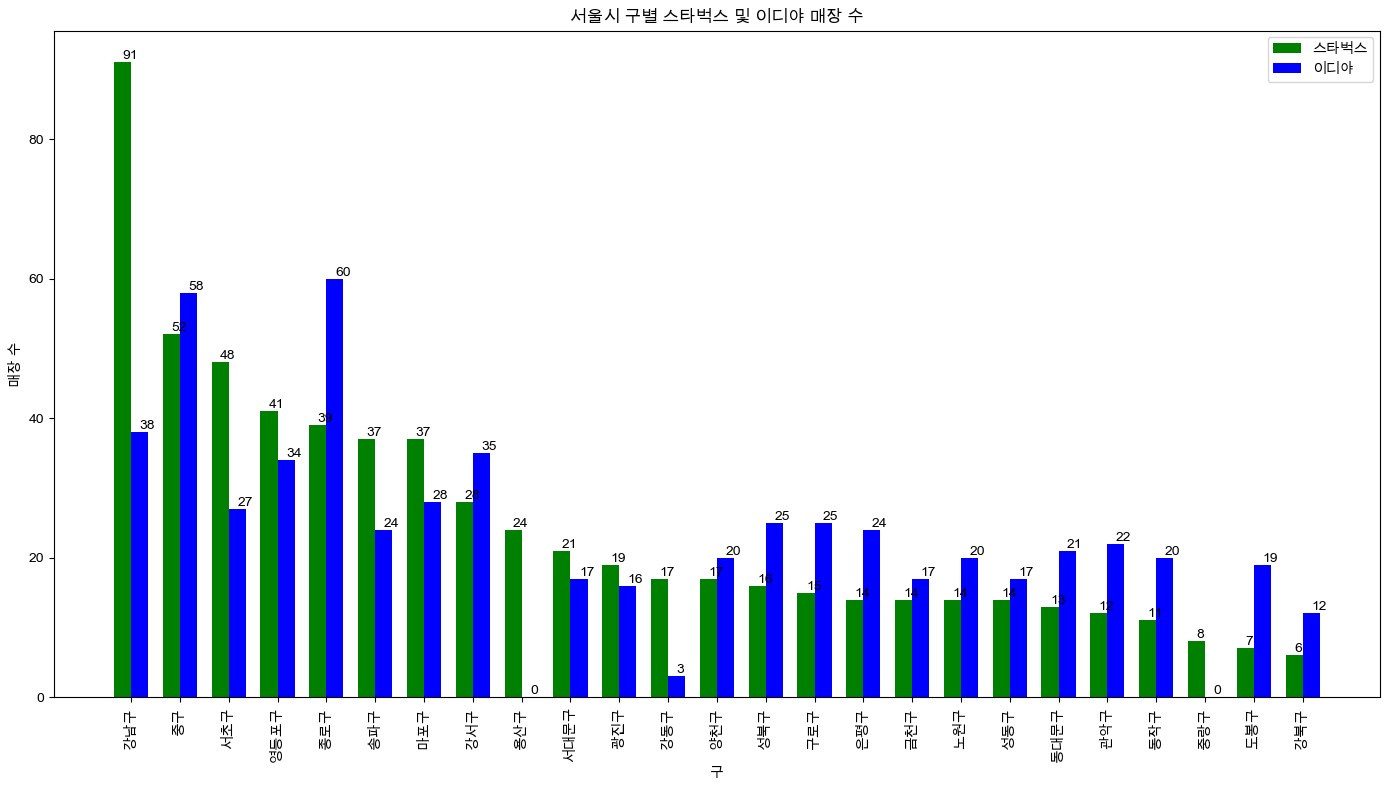

In [106]:
# 구별 매장 수 막대 그래프

plt.figure(figsize=(14, 8))
bar_width = 0.35
index = range(len(gu_data))

bar1 = plt.bar(index, gu_data['스타벅스'], bar_width, label='스타벅스', color="green")
bar2 = plt.bar([i + bar_width for i in index], gu_data['이디야'], bar_width, label='이디야', color="blue")

plt.xlabel('구')
plt.ylabel('매장 수')
plt.title('서울시 구별 스타벅스 및 이디야 매장 수')
plt.xticks([i + bar_width / 2 for i in index], gu_data.index, rotation=90)
plt.legend()

# 막대 그래프 위에 숫자 표시
for bar in bar1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom') 

for bar in bar2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom') 

plt.tight_layout()
plt.show()

In [121]:
# 구별 스타벅스, 이디야 매장 수를 원의 넓이로 시각화

my_map = folium.Map(
    location=[37.5502, 126.982],
    zoom_start=11
)

for idx, row in seoul_gu_center.iterrows():
    folium.CircleMarker(
        location = [row["lat"], row["lng"]],
        radius = int(gu_data.loc[row["시군구명"],"스타벅스"]),
        color = "green",
        fill = True,
        fill_color = "green",
    ).add_to(my_map)
    
    folium.CircleMarker(
        location = [row["lat"], row["lng"]],
        radius = int(gu_data.loc[row["시군구명"],"이디야"]),
        color = "blue",
        fill = True,
        fill_color = "blue",
    ).add_to(my_map)

my_map

In [125]:
# 정규화
gu_data_norm = gu_data / gu_data.max()
gu_data_norm.head()

스타벅스       이디야
구                       
강남구   1.000000  0.633333
중구    0.571429  0.966667
서초구   0.527473  0.450000
영등포구  0.450549  0.566667
종로구   0.428571  1.000000

<a id="구별-매장-분포도"></a>

In [127]:
# 구별 스타벅스, 이디야 정규화된 매장 수를 원의 넓이로 시각화

my_map = folium.Map(
    location=[37.5502, 126.982],
    zoom_start=11
)

for idx, row in seoul_gu_center.iterrows():
    folium.CircleMarker(
        location = [row["lat"], row["lng"]],
        radius = gu_data_norm.loc[row["시군구명"],"스타벅스"] * 70,
        color = "green",
        fill = True,
        fill_color = "green",
    ).add_to(my_map)
    
    folium.CircleMarker(
        location = [row["lat"], row["lng"]],
        radius = gu_data_norm.loc[row["시군구명"],"이디야"] * 70,
        color = "blue",
        fill = True,
        fill_color = "blue",
    ).add_to(my_map)

my_map

<a id="구별-매장-히트맵"></a>

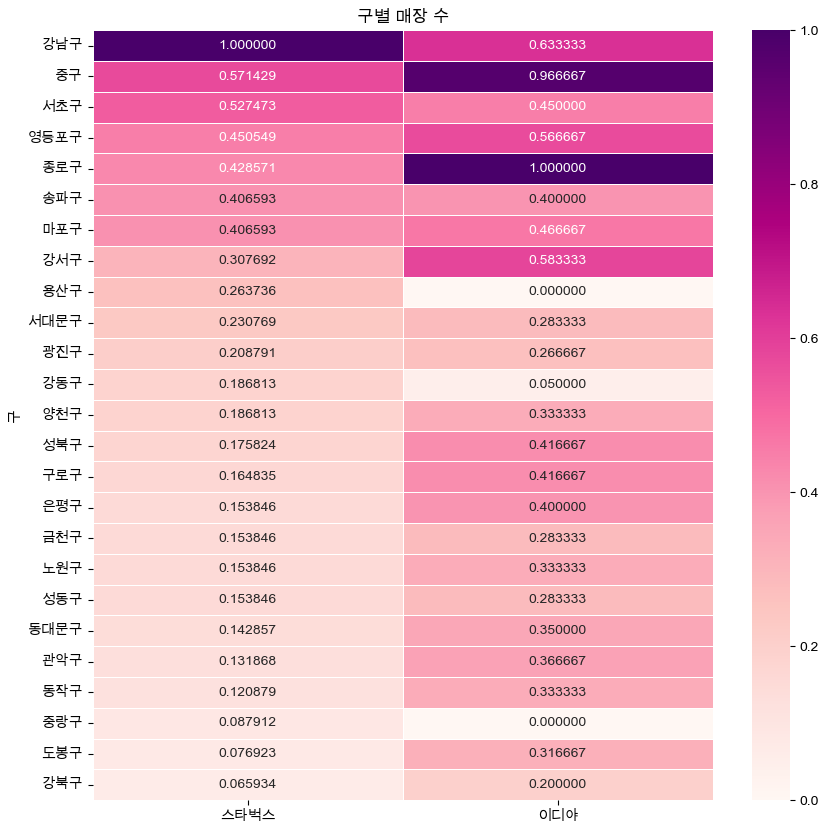

In [128]:
plt.figure(figsize=(10, 10))
sns.heatmap(
    gu_data_norm,
    annot=True,
    fmt="f",
    linewidths=0.5,
    cmap="RdPu"
)
plt.title("구별 매장 수")
plt.show()

### 분석결과

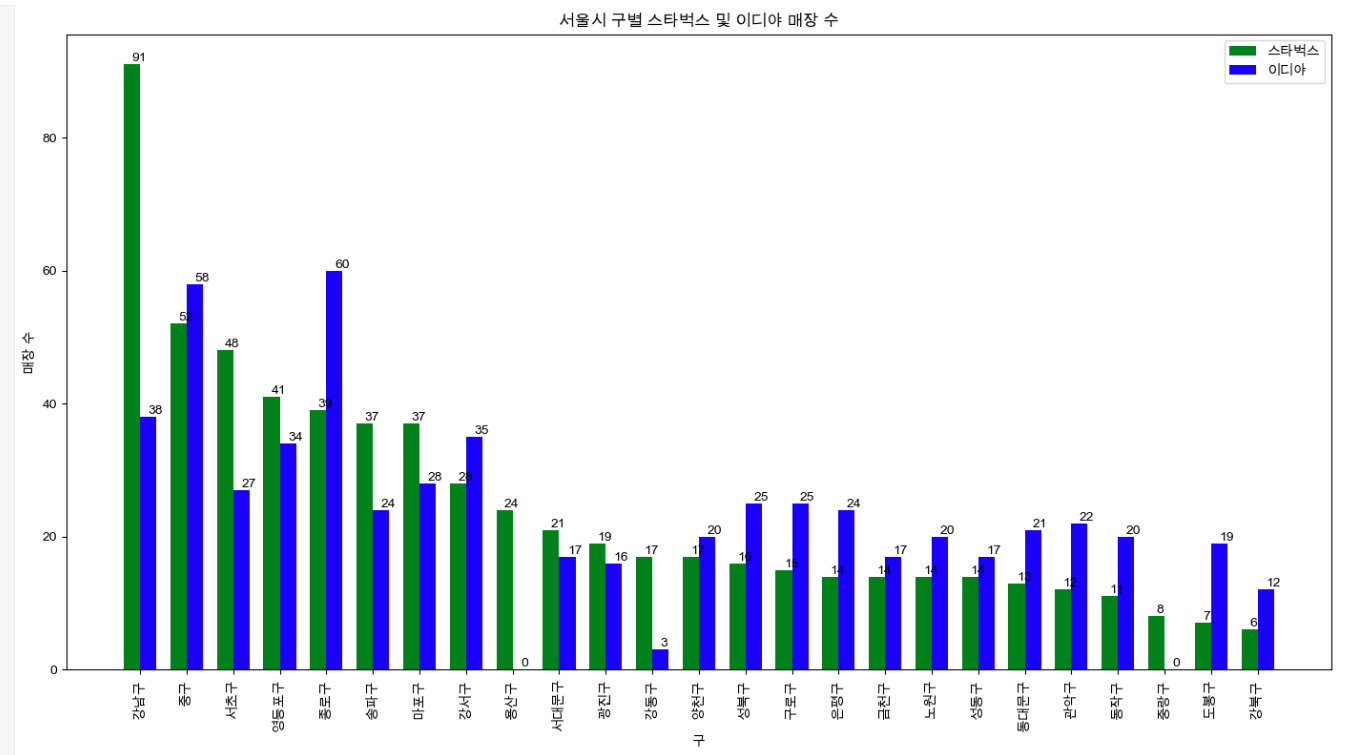

(1) <br>
[구별 매장 수 막대 그래프](#구별-매장-수-막대-그래프) 에서 스타벅스는 용산구에 24개의 매장을 두고 있는 반면, 이디야는 매장이 하나도 없습니다.  <br>
그리고 스타벅스는 강남구에 매장을 가장 많이 오픈한 반면, 이디야는 종로구에 매장을 가장 많이 운영하고 있습니다. 

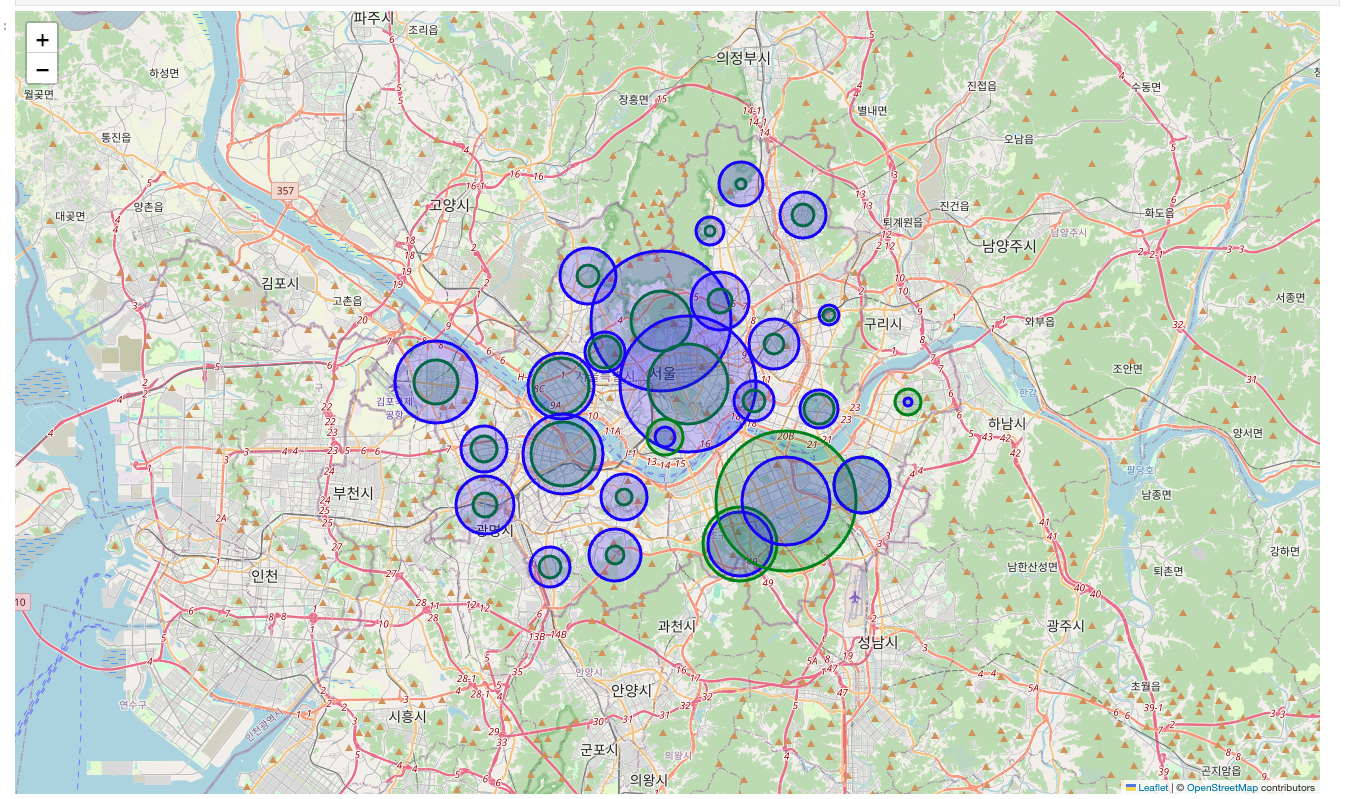

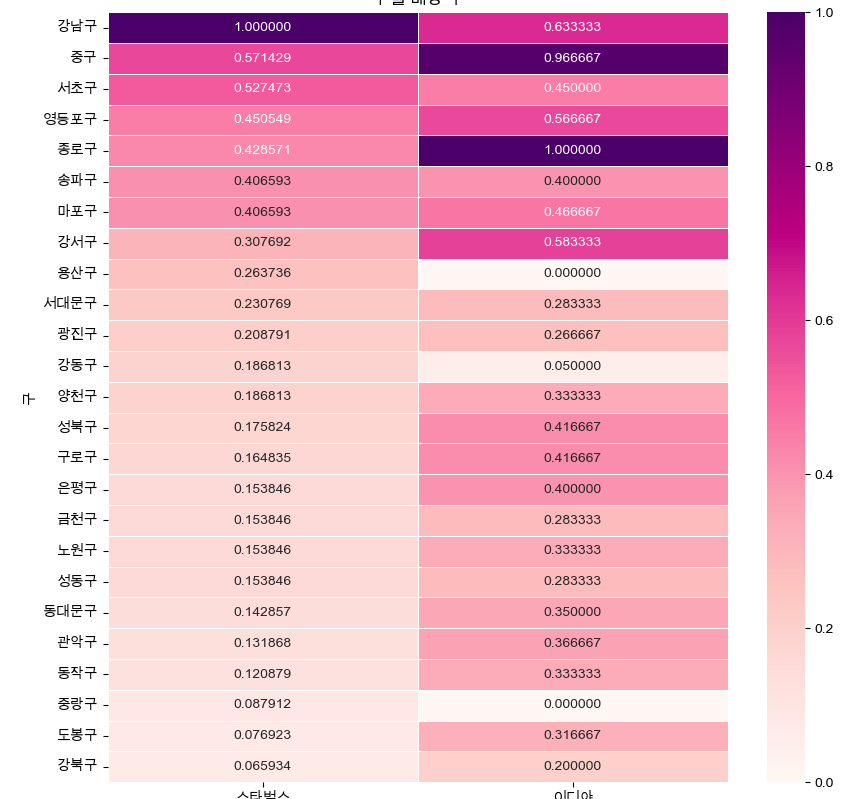

(2) <br>
[구별 매장 분포 지도 시각화](#구별-매장-분포도) 와 [구별 매장 분포 히트맵](#구별-매장-히트맵) 에서 스타벅스, 이디야의 구별 매장 분포도가 상이합니다. <br>
스타벅스의 매장은 강남, 중구, 서초구, 영등포구, 종로구, 송파구, 마포구에 몰려있음과 비교해서 이디야의 매장은 서울 전체 구에 골고루 매장이 분포되어 있는 편입니다.




(1), (2)에 따라 <br>
2024년 8월 기준 이디야커피는 스타벅스 커피 매장이 위치하는 곳에 매장을 위치시키는 것이라고 보기 힘듭니다. 